------
**You cannot apply any changes to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------


# Practical 2: Representing Sentences with Neural Models

In this second practical, we will train neural network models to obtain sentence representations. We can then use these sentence representations for a downstream task such as sentiment classification. 

In this notebook, we will help you to develop models for your experiments. But this time, next to completing the notebook, **you are expected to write a four-page scientific report with your findings**. Please still submit the notebook together with your scientific report so that we can reproduce your experiments. (Note: if you find it useful, you can split this notebook into multiple notebooks. If you do so, keep it mind that it should be possible for your TAs to reproduce the entire content of the notebooks without having to ask for clarifications or to copy and paste functions from one sub-notebook to another.) Make sure your code corresponds to the description you give in the report; we will deduct points if this is not the case.

**Important!** The main purpose of this lab is for you to learn how to answer research questions by experimenting and then writing a scientific report.
So you will be *judged by the quality of your report* but will lose points if your experiments are not reproducible.
You can find the requirements for the report at the end of this notebook.


### Data set
We will use the [Stanford Sentiment Treebank](https://nlp.stanford.edu/sentiment/) (SST), which provides sentences, their binary tree structure, and fine-grained sentiment scores.
This dataset is different from the one we used in the first practical. 
In Practical 1, a review consisted of several sentences, and we had one sentiment score for the whole review. Now, a review consists of a single sentence, and we have a sentiment score for each node in the binary tree that makes up the sentence, including the root node (i.e., we still have an overall sentiment score for the entire review). We will look at an example below.

In the first part of this practical we will only make use of the sentence tokens whereas in the second part we will also exploit the tree structure that is provided by the SST.

We will cover the following approaches:

- Bag-of-words (BOW)
- Continuous bag-of-words (CBOW)
- Deep continuous bag-of-words (Deep CBOW)
- LSTM
- Tree-LSTM


### Notebook Guide

##### Code folder structure

* The data is stored in `trees/` folder and if it is not already downloaded, it will be downloaded when training script it run.
* Checkpoints, logs, results (plots) etc are saved in corresponding folders.
* The main code scripts are organized as:
    * `data/`: Contains the scripts that define `Example` and `Vocabulary`
    * `models/`: Contains all the models in respective files
    * `utils/`: Helper functions
    * `train.py`: contains the main trainer function along with an evaluation function
    * `main.py`: The overall script that calls trainer/evaluation etc.
* The `NLP1_2021_Practical_2-final.ipynb` notebook contains the final code that can be run. Pre-generated logs are available in the notebook.

##### Detailed folder structure

```console
lab2/
├── NLP1_2021_Practical_2-final.ipynb
├── glove.840B.300d.sst.txt
├── googlenews.word2vec.300d.txt
├── trainDevTestTrees_PTB.zip
├── trees
│   ├── dev.txt
│   ├── test.txt
│   └── train.txt
├── data
│   ├── example.py
│   └── vocabulary.py
├── main.py
├── models
│   ├── __init__.py
│   ├── __pycache__
│   ├── bow.py
│   ├── cbow.py
│   ├── lstm.py
│   └── tree_lstm.py
├── train.py
├── checkpoints
│   ├── BOW_seed_0-best_model.ckpt
│   └── :
├── logs
│   ├── BOW-seeds_0_42_420.json
│   ├── BOW_seed_0-train_logs.json
│   └── :
├── results
│   ├── BOW-seed_0_results-best-ckpt.json
│   └── :
└── utils
    ├── io.py
    ├── plot.py
    └── text.py
```

##### Notebook structure and instructions

Broad structure:

1. We import all (external) requirements and functions from our own scripts.
2. For each class of models (`BOW`, .., `TreeLSTM`), we train the model (using 3 different seeds), save the best checkpoint and logs. We also evaluate the model on the test set and save its predictions that shall be used for later experimentation.
3. Then, we have a section per research question. In each of these sections, we specify the research question, implement the experiment and display/save the results.
4. Finally, we also add a section on data analysis where we analyze various aspects of the dataset. This was not explicitly part of the assignment, but before running any of our experiments, we thought it may be insightful to look at data.

The Table of contents is provided below for easy navigation.

### Table of contents

*  **[Imports](#imports)**
*  **[Training and Evaluation](#train-eval)**
    * [BOW](#bow)
    * [CBOW](#cbow)
    * [DeepCBOW](#deepcbow)
    * [PTDeepCBOW](#ptdeepcbow)
    * [LSTM](#lstm)
    * [TreeLSTM](#treelstm)

## Imports <a class="anchor" id="imports"></a>

In [1]:
# loads any change in scripts automatically so you don't have to restart the notebook

%load_ext autoreload
%autoreload 2

In [2]:
import os
from collections import defaultdict
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from train import (
    get_minibatch,
    prepare_minibatch,
    prepare_treelstm_minibatch,
    evaluate,
)
from main import (
    run_multiple_seed_experiments,
    eval_experiment,
    fix_seed,
    setup_data,
    setup_model,
    custom_evaluate,
    collect_all_subtrees,
)
from utils.io import load_json
from utils.plot import (
    plot_single_categorical_histogram,
    plot_multiple_categorical_histogram,
)

In [3]:
# set plt parameters for LaTeX fonts while plotting
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

## Training and Evaluation <a class="anchor" id="train-eval"></a>

### `BOW` <a class="anchor" id="bow"></a>

In [12]:
expt_args = {
    "model_name": "BOW",
    "model_args": {
        "embedding_dim": 5,
    },
    "optim_args": {
        "lr": 0.0005,
    },
    "train_args": {
        "num_iterations": 250000,
        "print_every": 1000,
        "eval_every": 1000,
    },
    "verbose": False,
    "expt_name": "",
}

:::::::::::::::::::::::: Seed : 0 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Configuring model :::
BOW(
  (embed): Embedding(18280, 5)
)
bias                     [5]          requires_grad=True
embed.weight             [18280, 5]   requires_grad=True

Total number of parameters: 91405

::: Configuring optimizer :::
::: Configuring training :::
Done training
Loading best model
best model iter 211000: train acc=0.7968, dev acc=0.3188, test acc=0.3186
::: Configuring plotting :::


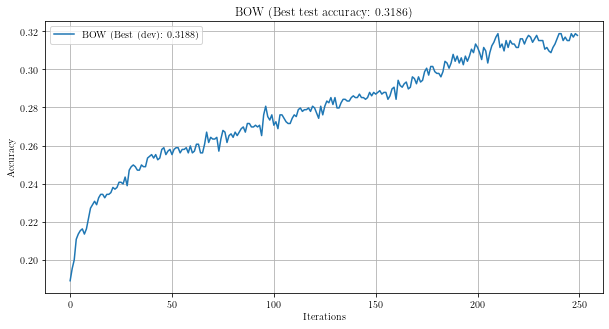

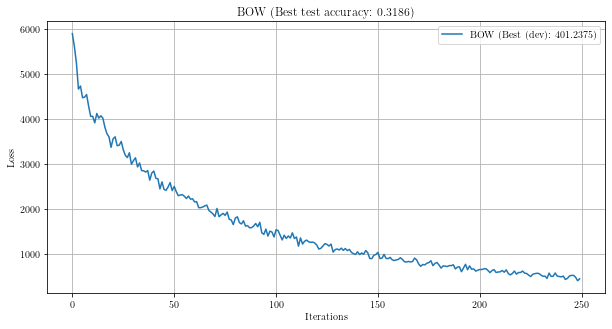

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 42 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Configuring model :::
BOW(
  (embed): Embedding(18280, 5)
)
bias                     [5]          requires_grad=True
embed.weight             [18280, 5]   requires_grad=True

Total number of parameters: 91405

::: Configuring optimizer :::
::: Configuring training :::
Done training
Loading best model
best model iter 242000: train acc=0.8324, dev acc=0.3124, test acc=0.3271
::: Configuring plotting :::


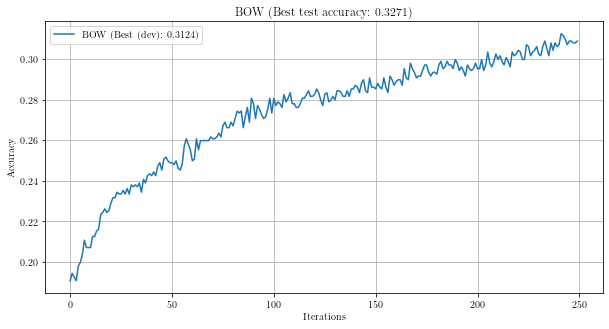

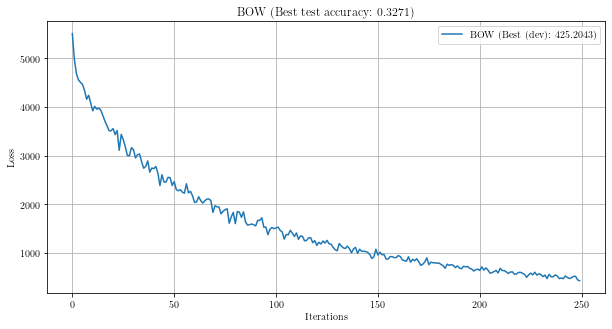

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 420 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Configuring model :::
BOW(
  (embed): Embedding(18280, 5)
)
bias                     [5]          requires_grad=True
embed.weight             [18280, 5]   requires_grad=True

Total number of parameters: 91405

::: Configuring optimizer :::
::: Configuring training :::
Done training
Loading best model
best model iter 198000: train acc=0.7757, dev acc=0.3479, test acc=0.3412
::: Configuring plotting :::


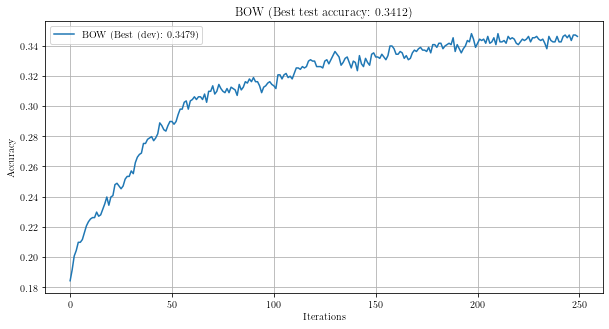

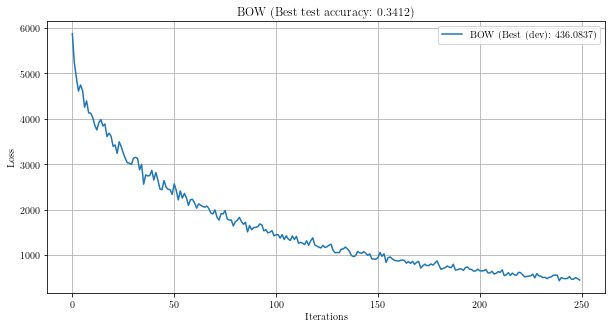

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
train	: Mean	: 0.8017 Std	: 0.0234
dev	: Mean	: 0.3264 Std	: 0.0154
test	: Mean	: 0.3290 Std	: 0.0093


In [13]:
best_agg_acc = run_multiple_seed_experiments(expt_args)

In [14]:
for phase in best_agg_acc:
    print(
        f"{phase}\t: Mean\t: {np.mean(best_agg_acc[phase]):.4f} Std\t: {np.std(best_agg_acc[phase]):.4f}"
    )

train	: Mean	: 0.8017 Std	: 0.0234
dev	: Mean	: 0.3264 Std	: 0.0154
test	: Mean	: 0.3290 Std	: 0.0093


In [15]:
test_args = {
    "model_name": expt_args["model_name"],
    "model_args": expt_args["model_args"],
    "eval_args": {},
    "ckpt_path": "./checkpoints/BOW_seed_%s-best_model.ckpt",
}

In [17]:
seeds = [0, 42, 420]

In [19]:
for seed in seeds:
    test_args["seed"] = seed
    test_args["ckpt_path"] = f"./checkpoints/{test_args['model_name']}_seed_{seed}-best_model.ckpt"

    print(f":::::::::::::::::::::::::: Evaluating {test_args['model_name']} Seed {seed} :::::::::::::::::::::::::: ")
    eval_experiment(**test_args)

:::::::::::::::::::::::::: Evaluating BOW Seed 0 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/BOW_seed_0-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating BOW Seed 42 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/BOW_seed_42-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating BOW Seed 420 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/BOW_seed_420-best_model-results.pt :::


### `CBOW` <a class="anchor" id="cbow"></a>

Disclaimer: This takes significant amount of time (~90mins) on a CPU machine. We have tested it on Mac M1.

In [20]:
expt_args = {
    "model_name": "CBOW",
    "model_args": {
        "embedding_dim": 300,
    },
    "optim_args": {
        "lr": 0.0001,
    },
    "train_args": {
        "num_iterations": 100000,
        "print_every": 1000,
        "eval_every": 1000,
    },
    "verbose": False,
    "expt_name": "",
}

:::::::::::::::::::::::: Seed : 0 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Configuring model :::
CBOW(
  (embed): Embedding(18280, 300)
  (projector): Linear(in_features=300, out_features=5, bias=True)
)
embed.weight             [18280, 300] requires_grad=True
projector.weight         [5, 300]     requires_grad=True
projector.bias           [5]          requires_grad=True

Total number of parameters: 5485505

::: Configuring optimizer :::
::: Configuring training :::
Done training
Loading best model
best model iter 96000: train acc=0.7333, dev acc=0.3615, test acc=0.3534
::: Configuring plotting :::


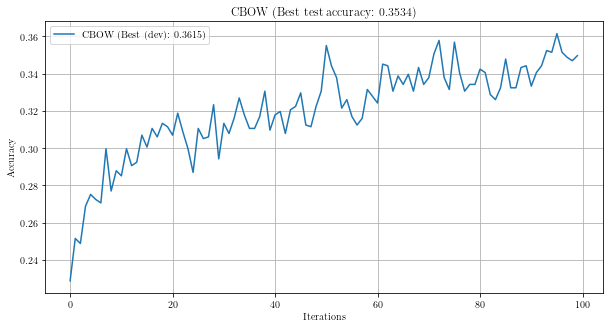

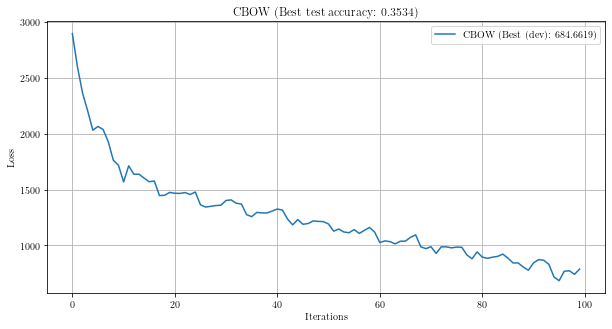

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 42 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Configuring model :::
CBOW(
  (embed): Embedding(18280, 300)
  (projector): Linear(in_features=300, out_features=5, bias=True)
)
embed.weight             [18280, 300] requires_grad=True
projector.weight         [5, 300]     requires_grad=True
projector.bias           [5]          requires_grad=True

Total number of parameters: 5485505

::: Configuring optimizer :::
::: Configuring training :::
Done training
Loading best model
best model iter 73000: train acc=0.6442, dev acc=0.3433, test acc=0.3186
::: Configuring plotting :::


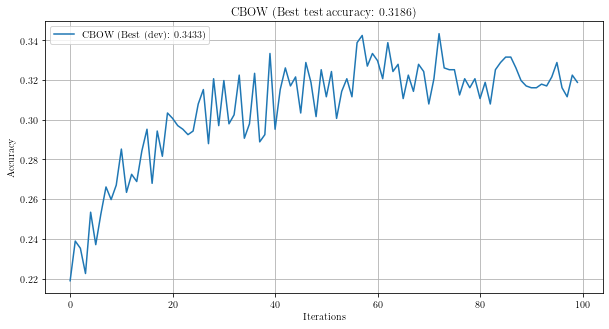

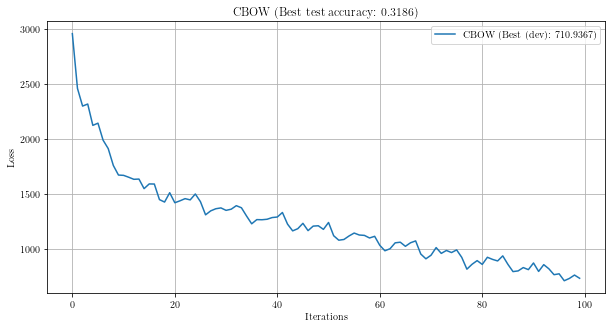

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 420 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Configuring model :::
CBOW(
  (embed): Embedding(18280, 300)
  (projector): Linear(in_features=300, out_features=5, bias=True)
)
embed.weight             [18280, 300] requires_grad=True
projector.weight         [5, 300]     requires_grad=True
projector.bias           [5]          requires_grad=True

Total number of parameters: 5485505

::: Configuring optimizer :::
::: Configuring training :::
Done training
Loading best model
best model iter 74000: train acc=0.6602, dev acc=0.3597, test acc=0.3724
::: Configuring plotting :::


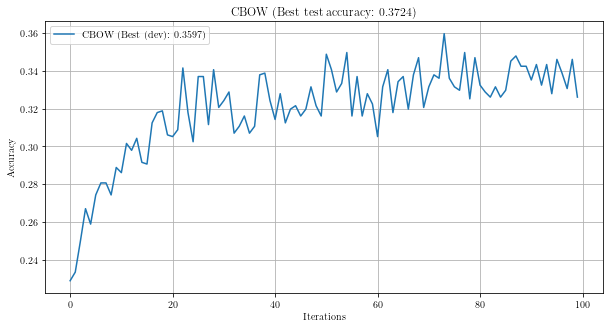

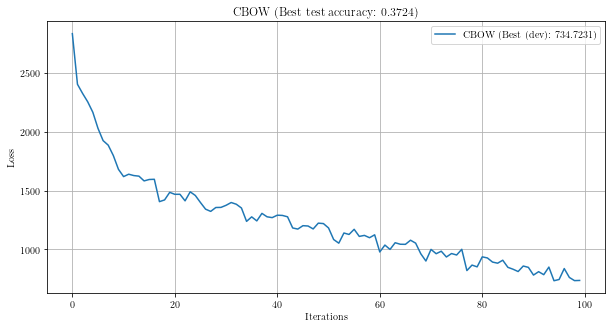

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
train	: Mean	: 0.6792 Std	: 0.0388
dev	: Mean	: 0.3548 Std	: 0.0082
test	: Mean	: 0.3481 Std	: 0.0223


In [21]:
best_agg_acc = run_multiple_seed_experiments(expt_args)

In [22]:
for phase in best_agg_acc:
    print(
        f"{phase}\t: Mean\t: {np.mean(best_agg_acc[phase]):.4f} Std\t: {np.std(best_agg_acc[phase]):.4f}"
    )

train	: Mean	: 0.6792 Std	: 0.0388
dev	: Mean	: 0.3548 Std	: 0.0082
test	: Mean	: 0.3481 Std	: 0.0223


In [24]:
test_args = {
    "model_name": expt_args["model_name"],
    "model_args": expt_args["model_args"],
    "eval_args": {},
    "ckpt_path": "./checkpoints/CBOW_seed_%s-best_model.ckpt",
}

In [25]:
for seed in seeds:
    test_args["seed"] = seed
    test_args["ckpt_path"] = f"./checkpoints/{test_args['model_name']}_seed_{seed}-best_model.ckpt"

    print(f":::::::::::::::::::::::::: Evaluating {test_args['model_name']} Seed {seed} :::::::::::::::::::::::::: ")
    eval_experiment(**test_args)

:::::::::::::::::::::::::: Evaluating CBOW Seed 0 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/CBOW_seed_0-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating CBOW Seed 42 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/CBOW_seed_42-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating CBOW Seed 420 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/CBOW_seed_420-best_model-results.pt :::


### `DeepCBOW` <a class="anchor" id="deepcbow"></a>

In [26]:
expt_args = {
    "model_name": "DeepCBOW",
    "model_args": {
        "embedding_dim": 300,
        "hidden_dim": 100,
        "output_dim": 5,
    },
    "optim_args": {
        "lr": 0.0005,
    },
    "train_args": {
        "num_iterations": 30000,
        "print_every": 1000,
        "eval_every": 1000,
    },
    "verbose": False,
}

:::::::::::::::::::::::: Seed : 0 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Configuring model :::
DeepCBOW(
  (net): Sequential(
    (0): Embedding(18280, 300)
    (1): Linear(in_features=300, out_features=100, bias=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Tanh()
    (5): Linear(in_features=100, out_features=5, bias=True)
  )
)
net.0.weight             [18280, 300] requires_grad=True
net.1.weight             [100, 300]   requires_grad=True
net.1.bias               [100]        requires_grad=True
net.3.weight             [100, 100]   requires_grad=True
net.3.bias               [100]        requires_grad=True
net.5.weight             [5, 100]     requires_grad=True
net.5.bias               [5]          requires_grad=True

Total number of parameters: 5524705

::: Configuring optimizer :::
::: Configuring training 

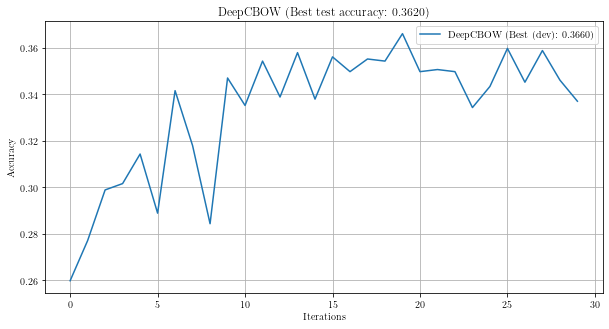

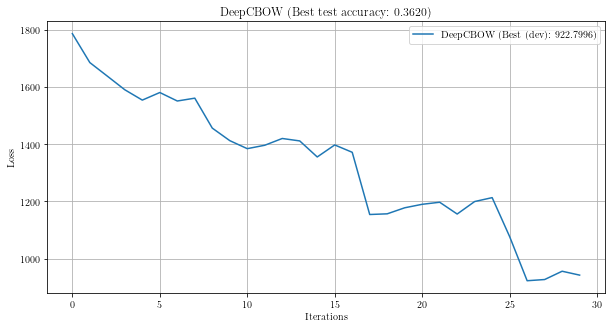

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 42 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Configuring model :::
DeepCBOW(
  (net): Sequential(
    (0): Embedding(18280, 300)
    (1): Linear(in_features=300, out_features=100, bias=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Tanh()
    (5): Linear(in_features=100, out_features=5, bias=True)
  )
)
net.0.weight             [18280, 300] requires_grad=True
net.1.weight             [100, 300]   requires_grad=True
net.1.bias               [100]        requires_grad=True
net.3.weight             [100, 100]   requires_grad=True
net.3.bias               [100]        requires_grad=True
net.5.weight             [5, 100]     requires_grad=True
net.5.bias               [5]          requires_gra

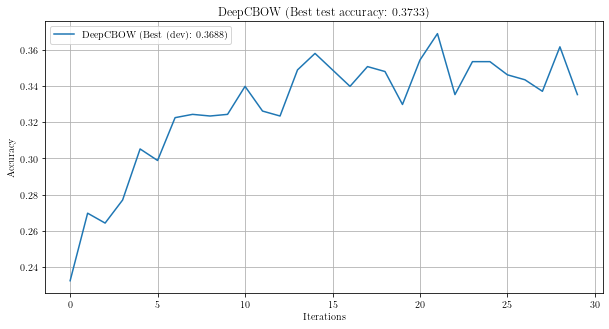

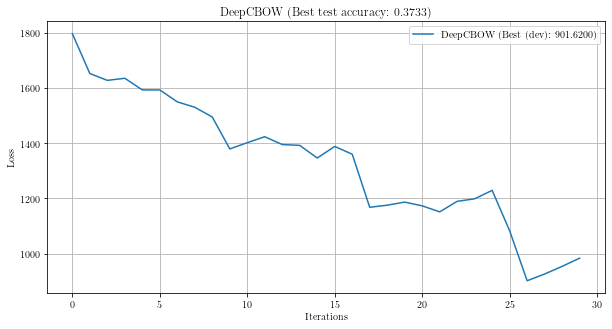

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 420 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Configuring model :::
DeepCBOW(
  (net): Sequential(
    (0): Embedding(18280, 300)
    (1): Linear(in_features=300, out_features=100, bias=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Tanh()
    (5): Linear(in_features=100, out_features=5, bias=True)
  )
)
net.0.weight             [18280, 300] requires_grad=True
net.1.weight             [100, 300]   requires_grad=True
net.1.bias               [100]        requires_grad=True
net.3.weight             [100, 100]   requires_grad=True
net.3.bias               [100]        requires_grad=True
net.5.weight             [5, 100]     requires_grad=True
net.5.bias               [5]          requires_gr

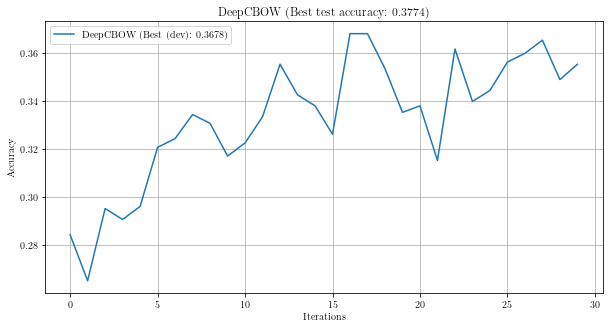

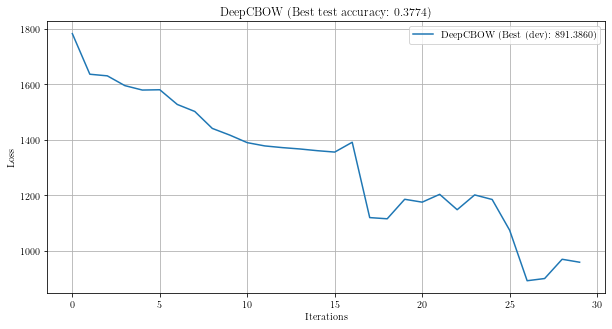

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
train	: Mean	: 0.5384 Std	: 0.0377
dev	: Mean	: 0.3675 Std	: 0.0011
test	: Mean	: 0.3709 Std	: 0.0065


In [27]:
best_agg_acc = run_multiple_seed_experiments(expt_args)

In [28]:
for phase in best_agg_acc:
    print(
        f"{phase}\t: Mean\t: {np.mean(best_agg_acc[phase]):.4f} Std\t: {np.std(best_agg_acc[phase]):.4f}"
    )

train	: Mean	: 0.5384 Std	: 0.0377
dev	: Mean	: 0.3675 Std	: 0.0011
test	: Mean	: 0.3709 Std	: 0.0065


In [29]:
test_args = {
    "model_name": expt_args["model_name"],
    "model_args": expt_args["model_args"],
    "eval_args": {},
    "ckpt_path": "./checkpoints/DeepCBOW_seed_%s-best_model.ckpt",
}

In [30]:
for seed in seeds:
    test_args["seed"] = seed
    test_args["ckpt_path"] = f"./checkpoints/{test_args['model_name']}_seed_{seed}-best_model.ckpt"

    print(f":::::::::::::::::::::::::: Evaluating {test_args['model_name']} Seed {seed} :::::::::::::::::::::::::: ")
    eval_experiment(**test_args)

:::::::::::::::::::::::::: Evaluating DeepCBOW Seed 0 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/DeepCBOW_seed_0-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating DeepCBOW Seed 42 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/DeepCBOW_seed_42-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating DeepCBOW Seed 420 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/DeepCBOW_seed_420-best_model-results.pt :::


### `PTDeepCBOW` <a class="anchor" id="ptdeepcbow"></a>

In [45]:
expt_args = {
    "model_name": "PTDeepCBOW",
    "model_args": {
        "embedding_dim": 300,
        "hidden_dim": 100,
        "output_dim": 5,
    },
    "optim_args": {
        "lr": 0.00001,
    },
    "train_args": {
        "num_iterations": 60000,
        "print_every": 1000,
        "eval_every": 1000,
    },
    "verbose": False,
    "use_pretrained_embeddings": True,
    "pretrained_embeddings_path": "./googlenews.word2vec.300d.txt",
    "expt_name": "w2v",
}

:::::::::::::::::::::::: Seed : 0 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
PTDeepCBOW(
  (net): Sequential(
    (0): Embedding(18922, 300)
    (1): Linear(in_features=300, out_features=100, bias=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Tanh()
    (5): Linear(in_features=100, out_features=5, bias=True)
  )
)
net.0.weight             [18922, 300] requires_grad=False
net.1.weight             [100, 300]   requires_grad=True
net.1.bias               [100]        requires_grad=True
net.3.weight             [100, 100]   requires_grad=True
net.3.bias               [100]        requires_grad=True
net.5.weight             [5, 100]     requires_grad=True
net.5.bias               [5]          requires_grad=True

Total number of parameters: 5717305

::: Configuring optimi

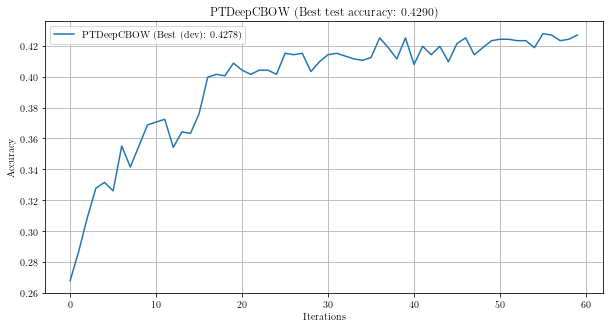

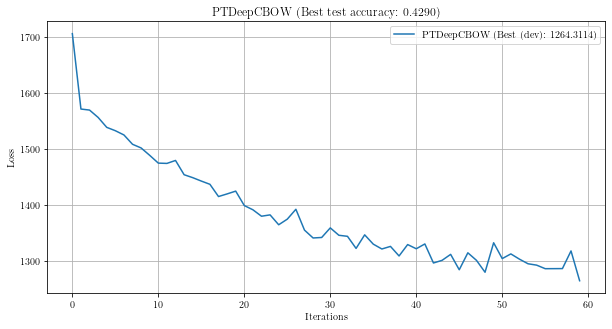

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 42 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
PTDeepCBOW(
  (net): Sequential(
    (0): Embedding(18922, 300)
    (1): Linear(in_features=300, out_features=100, bias=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Tanh()
    (5): Linear(in_features=100, out_features=5, bias=True)
  )
)
net.0.weight             [18922, 300] requires_grad=False
net.1.weight             [100, 300]   requires_grad=True
net.1.bias               [100]        requires_grad=True
net.3.weight             [100, 100]   requires_grad=True
net.3.bias               [100]        requires_grad=True
net.5.weight             [5, 100]     requires_grad=True
net.5.bias       

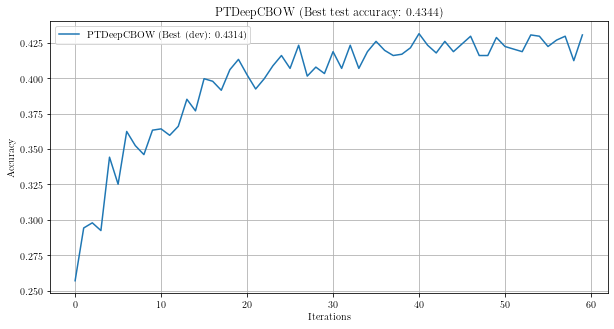

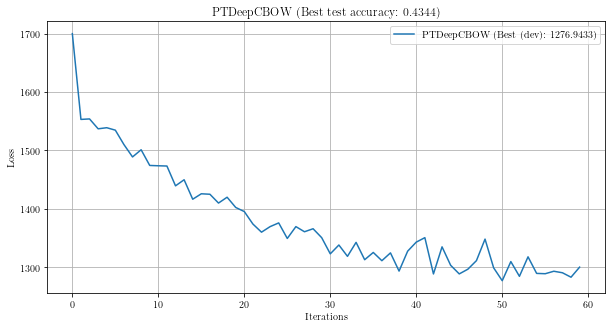

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 420 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
PTDeepCBOW(
  (net): Sequential(
    (0): Embedding(18922, 300)
    (1): Linear(in_features=300, out_features=100, bias=True)
    (2): Tanh()
    (3): Linear(in_features=100, out_features=100, bias=True)
    (4): Tanh()
    (5): Linear(in_features=100, out_features=5, bias=True)
  )
)
net.0.weight             [18922, 300] requires_grad=False
net.1.weight             [100, 300]   requires_grad=True
net.1.bias               [100]        requires_grad=True
net.3.weight             [100, 100]   requires_grad=True
net.3.bias               [100]        requires_grad=True
net.5.weight             [5, 100]     requires_grad=True
net.5.bias      

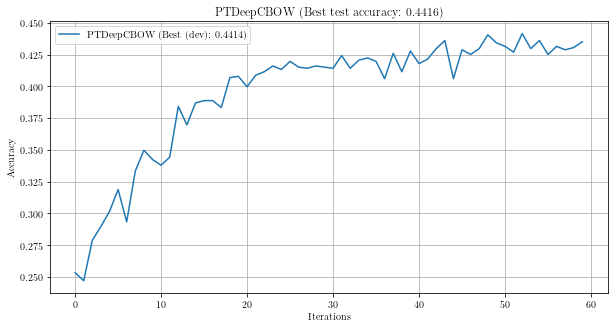

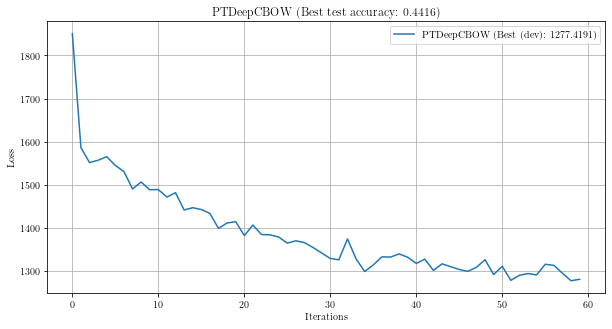

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
train	: Mean	: 0.4427 Std	: 0.0066
dev	: Mean	: 0.4335 Std	: 0.0058
test	: Mean	: 0.4350 Std	: 0.0052


In [46]:
best_agg_acc = run_multiple_seed_experiments(expt_args)

In [42]:
for phase in best_agg_acc:
    print(
        f"{phase}\t: Mean\t: {np.mean(best_agg_acc[phase]):.4f} Std\t: {np.std(best_agg_acc[phase]):.4f}"
    )

train	: Mean	: 0.4427 Std	: 0.0066
dev	: Mean	: 0.4335 Std	: 0.0058
test	: Mean	: 0.4350 Std	: 0.0052


In [43]:
test_args = {
    "model_name": expt_args["model_name"],
    "model_args": expt_args["model_args"],
    "eval_args": {},
    "use_pretrained_embeddings": expt_args["use_pretrained_embeddings"],
    "pretrained_embeddings_path": expt_args["pretrained_embeddings_path"],
    "ckpt_path": "./checkpoints/PTDeepCBOW_seed_%s-best_model.ckpt",
}

In [44]:
for seed in seeds:
    test_args["seed"] = seed
    test_args["ckpt_path"] = f"./checkpoints/{test_args['model_name']}_seed_{seed}-best_model.ckpt"

    print(f":::::::::::::::::::::::::: Evaluating {test_args['model_name']} Seed {seed} :::::::::::::::::::::::::: ")
    eval_experiment(**test_args)

:::::::::::::::::::::::::: Evaluating PTDeepCBOW Seed 0 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Saved results at results/PTDeepCBOW_seed_0-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating PTDeepCBOW Seed 42 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Saved results at results/PTDeepCBOW_seed_42-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating PTDeepCBOW Seed 420 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Saved results at results/PTDeepCBOW_seed_420-best_model-results.pt :::


### `LSTM` <a class="anchor" id="lstm"></a>

In [47]:
expt_args = {
    "model_name": "LSTMClassifier",
    "model_args": {
        "embedding_dim": 300,
        "hidden_dim": 168,
        "output_dim": 5,
    },
    "optim_args": {
        "lr": 2e-4,
    },
    "train_args": {
        "num_iterations": 2000,
        "print_every": 25,
        "eval_every": 25,
        "batch_size": 25,
        "batch_fn": get_minibatch,
        "eval_fn": evaluate,
        "prep_fn": prepare_minibatch,
    },
    "verbose": False,
    "use_pretrained_embeddings": True,
    "pretrained_embeddings_path": "./googlenews.word2vec.300d.txt",
    "expt_name": "w2v",
}

:::::::::::::::::::::::: Seed : 0 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
LSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=False
rnn.input_projectors.weight [672, 1200]  requires_grad=True
rnn.input_projectors.bias [672]        requires_grad=True
rnn.hidden_projectors.weight [672, 672]   requires_grad=True
rnn.hidden_projectors.bias [672]        requires_grad=True
output_layer.1.weight    [5, 168]     requires_grad=True
output_layer.1.bias      [5]          requires_grad=True

Total number of parameters: 6936773

::: Configuring optimizer :::
::: Configuring training :::
Done train

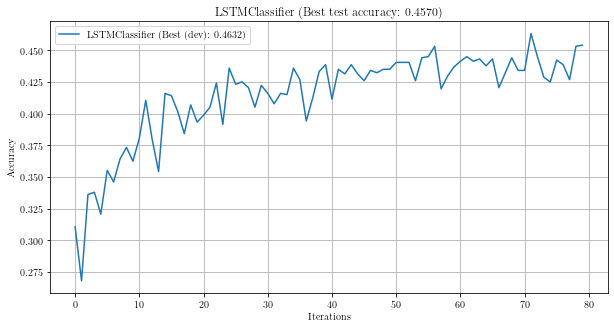

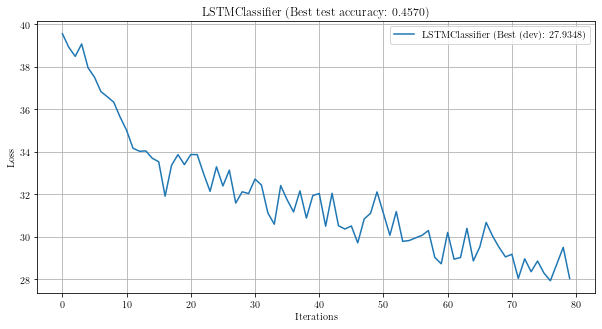

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 42 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
LSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=False
rnn.input_projectors.weight [672, 1200]  requires_grad=True
rnn.input_projectors.bias [672]        requires_grad=True
rnn.hidden_projectors.weight [672, 672]   requires_grad=True
rnn.hidden_projectors.bias [672]        requires_grad=True
output_layer.1.weight    [5, 168]     requires_grad=True
output_layer.1.bias      [5]          requires_grad=True

Total 

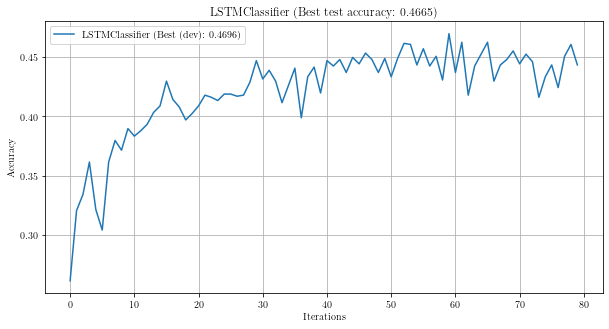

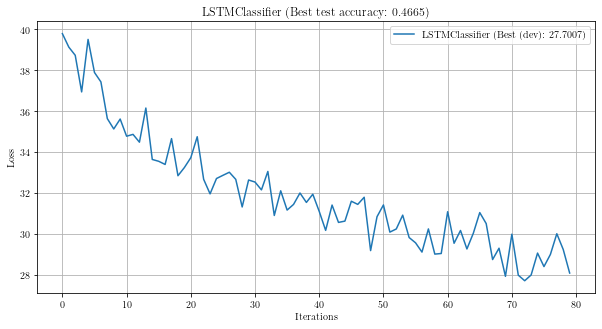

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 420 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
LSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=False
rnn.input_projectors.weight [672, 1200]  requires_grad=True
rnn.input_projectors.bias [672]        requires_grad=True
rnn.hidden_projectors.weight [672, 672]   requires_grad=True
rnn.hidden_projectors.bias [672]        requires_grad=True
output_layer.1.weight    [5, 168]     requires_grad=True
output_layer.1.bias      [5]          requires_grad=True

Total

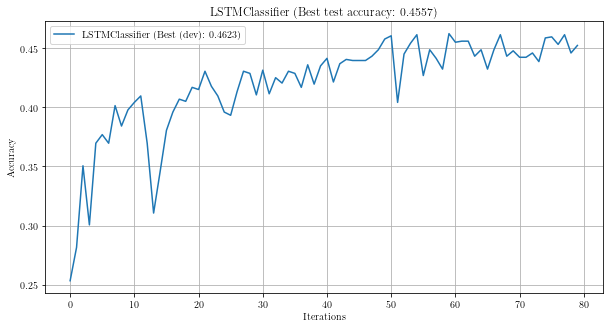

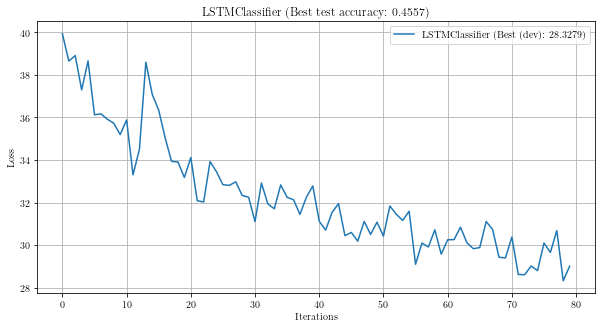

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
train	: Mean	: 0.5132 Std	: 0.0121
dev	: Mean	: 0.4650 Std	: 0.0032
test	: Mean	: 0.4597 Std	: 0.0048


In [48]:
best_agg_acc = run_multiple_seed_experiments(expt_args)

In [49]:
for phase in best_agg_acc:
    print(
        f"{phase}\t: Mean\t: {np.mean(best_agg_acc[phase]):.4f} Std\t: {np.std(best_agg_acc[phase]):.4f}"
    )

train	: Mean	: 0.5132 Std	: 0.0121
dev	: Mean	: 0.4650 Std	: 0.0032
test	: Mean	: 0.4597 Std	: 0.0048


In [51]:
test_args = {
    "model_name": expt_args["model_name"],
    "model_args": expt_args["model_args"],
    "ckpt_path": "./checkpoints/LSTMClassifier_seed_%s-best_model.ckpt",
    "eval_args": {
        "batch_fn": get_minibatch,
        "prep_fn": prepare_minibatch,
        "batch_size": 25,
    },
    "use_pretrained_embeddings": expt_args["use_pretrained_embeddings"],
    "pretrained_embeddings_path": expt_args["pretrained_embeddings_path"],
}

In [52]:
for seed in seeds:
    test_args["seed"] = seed
    test_args["ckpt_path"] = f"./checkpoints/{test_args['model_name']}_seed_{seed}-best_model.ckpt"

    print(f":::::::::::::::::::::::::: Evaluating {test_args['model_name']} Seed {seed} :::::::::::::::::::::::::: ")
    eval_experiment(**test_args)

:::::::::::::::::::::::::: Evaluating LSTMClassifier Seed 0 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Saved results at results/LSTMClassifier_seed_0-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating LSTMClassifier Seed 42 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Saved results at results/LSTMClassifier_seed_42-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating LSTMClassifier Seed 420 :::::::::::::::::::::::::: 
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Saved results at results/LSTMClassifier_seed_420-best_model-results.pt :::


### `LSTMTree` <a class="anchor" id="treelstm"></a>

In [37]:
expt_args = {
    "model_name": "TreeLSTMClassifier",
    "model_args": {
        "embedding_dim": 300,
        "hidden_dim": 150,
        "output_dim": 5,
    },
    "optim_args": {
        "lr": 2e-4,
    },
    "train_args": {
        "num_iterations": 5000,
        "print_every": 250,
        "eval_every": 250,
        "batch_size": 25,
        "batch_fn": get_minibatch,
        "eval_fn": evaluate,
        "prep_fn": prepare_treelstm_minibatch,
    },
    "verbose": False,
    "use_pretrained_embeddings": True,
    "pretrained_embeddings_path": "./glove.840B.300d.sst.txt",
    "expt_name": "TreeLSTMClassifier-seeds_0_42_420-glove"
}

:::::::::::::::::::::::: Seed : 0 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 20727 	 Vectors shape:  (20727, 300)
::: Configuring model :::
TreeLSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (treelstm): TreeLSTM(
    (reduce): TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
treelstm.reduce.reduce_layer.weight [750, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [750]        requires_grad=True
treelstm.proj_x.weight   [150, 300]   requires_grad=True
treelstm.proj_x.bias     [150]       

/Users/piyush/miniforge3/envs/nlp1labs/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Done training
Loading best model
best model iter 4000: train acc=0.5679, dev acc=0.4705, test acc=0.4624
::: Configuring plotting :::


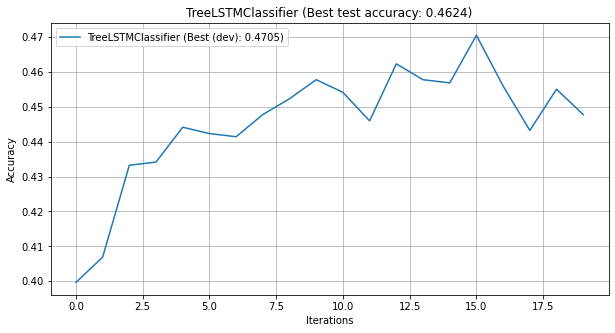

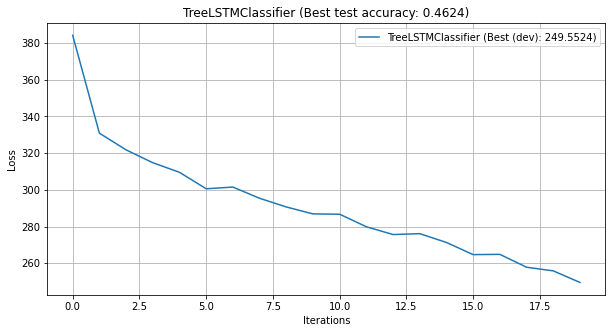

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 42 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 20727 	 Vectors shape:  (20727, 300)
::: Configuring model :::
TreeLSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (treelstm): TreeLSTM(
    (reduce): TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
treelstm.reduce.reduce_layer.weight [750, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [750]        requires_grad

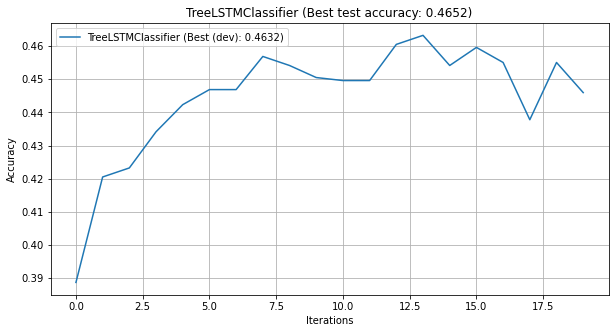

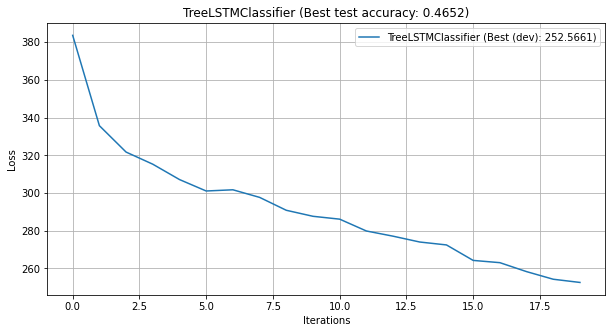

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 420 ::::::::::::::::::::::::
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 20727 	 Vectors shape:  (20727, 300)
::: Configuring model :::
TreeLSTMClassifier(
  (embed): Embedding(20727, 300, padding_idx=1)
  (treelstm): TreeLSTM(
    (reduce): TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [20727, 300] requires_grad=False
treelstm.reduce.reduce_layer.weight [750, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [750]        requires_gra

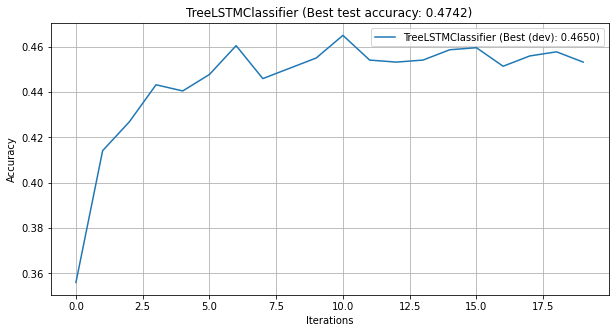

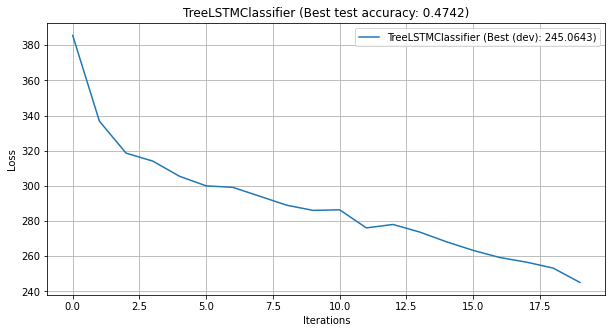

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
train	: Mean	: 0.5540 Std	: 0.0130
dev	: Mean	: 0.4662 Std	: 0.0031
test	: Mean	: 0.4673 Std	: 0.0050


In [38]:
best_agg_acc = run_multiple_seed_experiments(expt_args)

In [8]:
for phase in best_agg_acc:
    print(
        f"{phase}\t: Mean\t: {np.mean(best_agg_acc[phase]):.4f} Std\t: {np.std(best_agg_acc[phase]):.4f}"
    )

train	: Mean	: 0.5007 Std	: 0.0053
dev	: Mean	: 0.4553 Std	: 0.0028
test	: Mean	: 0.4623 Std	: 0.0030


### Generating tabular results

In [36]:
files = glob("logs/*-seeds_*.json")

In [31]:
models = [os.path.basename(f).split("-seeds")[0] for f in files]
df = pd.DataFrame(None, index=models, columns=["Accuracy"])

for f in files:
    model = os.path.basename(f).split("-seeds")[0]
    results = load_json(f)
    
    mean, std = np.mean(results["test"]), np.std(results["test"])
    mean = np.round(mean, 3)
    std = np.round(std, 3)
    df.loc[model, "Accuracy"] = f"${mean} \pm {std}$"

# df.reset_index("Method")

In [33]:
print(df.to_latex())

\begin{tabular}{ll}
\toprule
{} &           Accuracy \\
\midrule
PTDeepCBOW         &  \$0.442 \textbackslash pm 0.002\$ \\
DeepCBOW           &  \$0.371 \textbackslash pm 0.007\$ \\
CBOW               &  \$0.348 \textbackslash pm 0.022\$ \\
LSTMClassifier     &   \$0.46 \textbackslash pm 0.005\$ \\
TreeLSTMClassifier &  \$0.462 \textbackslash pm 0.003\$ \\
BOW                &  \$0.329 \textbackslash pm 0.009\$ \\
\bottomrule
\end{tabular}



### Evaluate each experiment and save per-data-point results

In [225]:
seeds = [0, 42, 420]

In [231]:
# note: we are using all 420 seed models for evaluation

configs = [
    {
        "model_name": "BOW",
        "model_args": {
            "embedding_dim": 5,
        },
        "eval_args": {},
        "ckpt_path": "./checkpoints/BOW_seed_%s-best_model.ckpt",
    },
    {
        "model_name": "CBOW",
        "model_args": {
            "embedding_dim": 300,
        },
        "eval_args": {},
        "ckpt_path": "./checkpoints/CBOW_seed_%s-best_model.ckpt",

    },
    {
        "model_name": "DeepCBOW",
        "model_args": {
            "embedding_dim": 300,
            "hidden_dim": 100,
            "output_dim": 5,
        },
        "eval_args": {},
        "ckpt_path": "./checkpoints/DeepCBOW_seed_%s-best_model.ckpt",
    },
    {
        "model_name": "PTDeepCBOW",
        "model_args": {
            "embedding_dim": 300,
            "hidden_dim": 100,
            "output_dim": 5,
        },
        "eval_args": {},
        "use_pretrained_embeddings": True,
        "pretrained_embeddings_path": "./googlenews.word2vec.300d.txt",
        "ckpt_path": "./checkpoints/PTDeepCBOW_seed_%s-best_model.ckpt",
    },
    {
        "model_name": "LSTMClassifier",
        "model_args": {
            "embedding_dim": 300,
            "hidden_dim": 168,
            "output_dim": 5,
        },
        "ckpt_path": "./checkpoints/LSTMClassifier_seed_%s-best_model.ckpt",
        "eval_args": {
            "batch_fn": get_minibatch,
            "prep_fn": prepare_minibatch,
            "batch_size": 25,
        },
        "use_pretrained_embeddings": True,
        "pretrained_embeddings_path": "./googlenews.word2vec.300d.txt",
    },
    {
        "model_name": "TreeLSTMClassifier",
        "model_args": {
            "embedding_dim": 300,
            "hidden_dim": 150,
            "output_dim": 5,
        },
        "ckpt_path": "./checkpoints/TreeLSTMClassifier_seed_%s-best_model.ckpt",
        "eval_args": {
            "batch_size": 25,
            "batch_fn": get_minibatch,
            "prep_fn": prepare_treelstm_minibatch,
        },
        "use_pretrained_embeddings": True,
        "pretrained_embeddings_path": "./googlenews.word2vec.300d.txt",
    },
]

In [233]:
for seed in seeds:
    for expt_args in configs:
        expt_args["seed"] = seed
        expt_args["ckpt_path"] = f"./checkpoints/{expt_args['model_name']}_seed_{seed}-best_model.ckpt"

        print(f":::::::::::::::::::::::::: Evaluating {expt_args['model_name']} Seed {seed} :::::::::::::::::::::::::: ")
        eval_experiment(**expt_args)

:::::::::::::::::::::::::: Evaluating BOW Seed 0 :::::::::::::::::::::::::: 
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/BOW_seed_0-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating CBOW Seed 0 :::::::::::::::::::::::::: 
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/CBOW_seed_0-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating DeepCBOW Seed 0 :::::::::::::::::::::::::: 
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using training dataset to create vocabulary. :::
Vocabulary size: 18280
::: Saved results at results/DeepCBOW_seed_0-best_model-results.pt :::
:::::::::::::::::::::::::: Evaluating PTDeepCBOW Seed 0 :::::::::::::::::::::::::: 
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 

### How important is the word order for this task?

##### LSTM

In [217]:
accuracy = {
    "shuffle=True": [],
    "shuffle=False": [],
}

seeds = [0, 42, 420]
eval_args = {
    "batch_fn": get_minibatch,
    "prep_fn": prepare_minibatch,
    "batch_size": 25,
}

for seed in seeds:

    # fix seed
    fix_seed(seed)

    # load data
    _, _, test_data, v, t2i, i2t = setup_data(
        use_pretrained_embeddings=True,
        pretrained_embeddings_path="./googlenews.word2vec.300d.txt",
    )

    # load model
    model = setup_model("LSTMClassifier", {"embedding_dim": 300, "hidden_dim": 168, "output_dim": 5,}, v=v)
    ckpt = torch.load(f"./checkpoints/LSTMClassifier_seed_{seed}-best_model.ckpt")
    model.load_state_dict(ckpt["state_dict"])

    # non shuffled results
    results = custom_evaluate(model, test_data, **eval_args)
    accuracy[f"shuffle=False"].append(np.mean(results['target'] == results['prediction']))

    # shuffle words in sentences of test data
    for ex in test_data:
        np.random.shuffle(ex.tokens)

    # shuffled results
    results = custom_evaluate(model, test_data, **eval_args)
    accuracy[f"shuffle=True"].append(np.mean(results['target'] == results['prediction']))

::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)


In [221]:
print("shuffle=True", f"${np.mean(accuracy['shuffle=True']):.3f} \pm {np.std(accuracy['shuffle=True']):.3f}$")
print("shuffle=False", f"${np.mean(accuracy['shuffle=False']):.3f} \pm {np.std(accuracy['shuffle=False']):.3f}$")

shuffle=True $0.445 \pm 0.002$
shuffle=False $0.460 \pm 0.005$


##### TreeLSTM

In [223]:
accuracy = {
    "shuffle=True": [],
    "shuffle=False": [],
}

seeds = [0, 42, 420]
eval_args = {
    "batch_fn": get_minibatch,
    "prep_fn": prepare_treelstm_minibatch,
    "batch_size": 25,
}

for seed in seeds:

    # fix seed
    fix_seed(seed)

    # load data
    _, _, test_data, v, t2i, i2t = setup_data(
        use_pretrained_embeddings=True,
        pretrained_embeddings_path="./googlenews.word2vec.300d.txt",
    )

    # load model
    model = setup_model("TreeLSTMClassifier", {"embedding_dim": 300, "hidden_dim": 150, "output_dim": 5,}, v=v)
    ckpt = torch.load(f"./checkpoints/TreeLSTMClassifier_seed_{seed}-best_model.ckpt")
    model.load_state_dict(ckpt["state_dict"])

    # non shuffled results
    results = custom_evaluate(model, test_data, **eval_args)
    accuracy[f"shuffle=False"].append(np.mean(results['target'] == results['prediction']))

    # shuffle words in sentences of test data
    for ex in test_data:
        np.random.shuffle(ex.tokens)

    # shuffled results
    results = custom_evaluate(model, test_data, **eval_args)
    accuracy[f"shuffle=True"].append(np.mean(results['target'] == results['prediction']))

::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)


/Users/piyush/miniforge3/envs/nlp1labs/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)


In [224]:
print("shuffle=True", f"${np.mean(accuracy['shuffle=True']):.3f} \pm {np.std(accuracy['shuffle=True']):.3f}$")
print("shuffle=False", f"${np.mean(accuracy['shuffle=False']):.3f} \pm {np.std(accuracy['shuffle=False']):.3f}$")

shuffle=True $0.431 \pm 0.006$
shuffle=False $0.462 \pm 0.003$


### Does the tree structure help to get a better accuracy?

See paper for details.

### How does performance depend on the sentence length? Compare the various models. Is there a model that does better on longer sentences? If so, why?

In [241]:
files = glob(os.path.join("results", "*-best_model-results.pt"))
models = np.unique([os.path.basename(f).split("_seed_")[0] for f in files])

In [260]:
mean_vs_sent_len = defaultdict(list)
stdv_vs_sent_len = defaultdict(list)

for model in models:

    model_test_accs = []
    for seed in seeds:
        f = os.path.join(f"./results/{model}_seed_{seed}-best_model-results.pt")
        R = torch.load(f)

        df = pd.DataFrame(None, columns=["Sentence length", "Prediction", "Target"])
        df["Sentence length"] = [len(r.tokens) for r in R["example"]]
        df["Prediction"] = R["prediction"]
        df["Target"] = R["target"]
        df.sort_values(by="Sentence length", inplace=True)

        uniq_sent_lens = df["Sentence length"].unique()
        min_sent_len = np.min(uniq_sent_lens)
        max_sent_len = np.max(uniq_sent_lens)

        sent_lens = list(range(min_sent_len, 45 + 1))
        test_accs = []

        for i, l in enumerate(sent_lens):
            ngbd = list(range(l - 2, l + 2))
            if l == 45:
                ngbd = list(range(max(l - 2, min_sent_len), max_sent_len))

            subdf = df[df["Sentence length"].isin(ngbd)]

            acc = (subdf["Prediction"] == subdf["Target"]).sum() / subdf.shape[0]
            test_accs.append(acc)

        model_test_accs.append(test_accs)

    mean_vs_sent_len[model] = np.mean(np.array(model_test_accs), axis=0)
    stdv_vs_sent_len[model] = np.std(np.array(model_test_accs), axis=0)

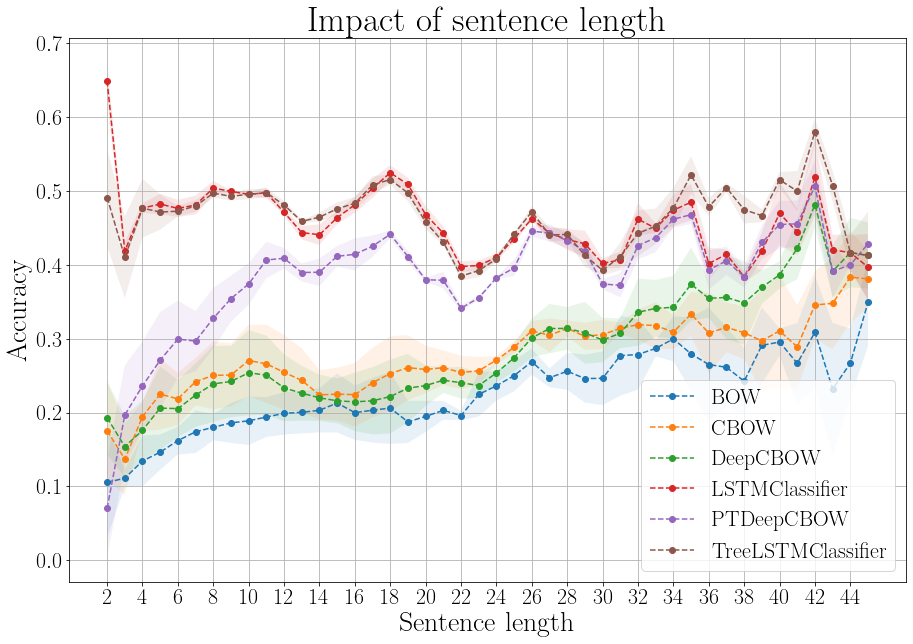

In [263]:
titlesize=35
tickssize=22
labelsize=28

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

ax.grid()
ax.set_title("Impact of sentence length", fontsize=titlesize)
ax.set_xlabel("Sentence length", fontsize=labelsize)
ax.set_ylabel("Accuracy", fontsize=labelsize)

for model_name in mean_vs_sent_len:
    ax.plot(sent_lens, mean_vs_sent_len[model_name], "--o", label=model_name)
    ax.fill_between(
        sent_lens,
        mean_vs_sent_len[model_name] - stdv_vs_sent_len[model_name],
        mean_vs_sent_len[model_name] + stdv_vs_sent_len[model_name],
        alpha=0.1
    )

ax.set_xticks(np.array(sent_lens)[::2])
ax.legend(fontsize=tickssize)

ax.tick_params(axis="x", labelsize=tickssize)
ax.tick_params(axis="y", labelsize=tickssize)

plt.savefig("./results/impact_of_sent_len.pdf", bbox_inches="tight")
plt.show()

### When making a wrong prediction, can you figure out at what point in the tree (sentence) the model fails? You can make a prediction at each node to investigate.

* **Quantitative analysis**:
    * For a given node, how does the model mispredicts at a given node w.r.t. to the node height?

In [35]:
def get_node_mispredictions_vs_height(model, examples, use_head_label=False):
    subexamples, idtracker = collect_all_subtrees(examples, use_head_label=False)
    R = custom_evaluate(model, subexamples, **eval_args)
    R["height"] = [r.tree.height() for r in R["example"]]

    mispredictions_vs_height = defaultdict(list)
    all_vs_height = defaultdict(list)

    for i in range(len(R["example"])):
        ex, p, t, h = R["example"][i], R["prediction"][i], R["target"][i], R["height"][i]
        all_vs_height[h].append(ex)
        if p != t:
            mispredictions_vs_height[h].append(ex)
    
    return mispredictions_vs_height, all_vs_height


def construct_df_of_misprediction_fraction(mispredictions_vs_height, all_vs_height):
    df = pd.DataFrame(None)
    df["height"] = all_vs_height.keys()
    df["mispredictions"] = [len(mispredictions_vs_height[k]) /len(all_vs_height[k])  for k in all_vs_height.keys()]
    df["corpredictions"] = [len(corpredictions_vs_height[k]) /len(all_vs_height[k])  for k in all_vs_height.keys()]
    df["total"] = df["mispredictions"] + df["corpredictions"]
    return df

::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)


/Users/piyush/miniforge3/envs/nlp1labs/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


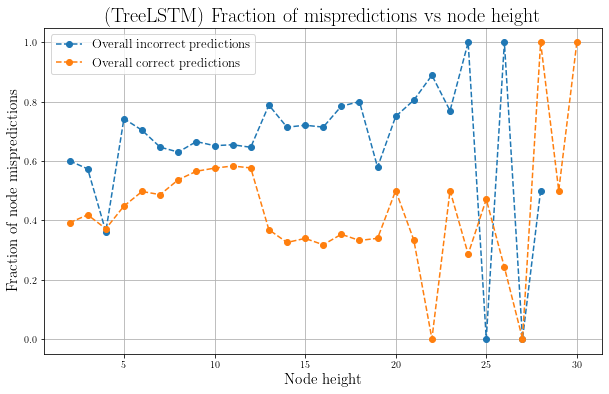

::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)


/Users/piyush/miniforge3/envs/nlp1labs/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


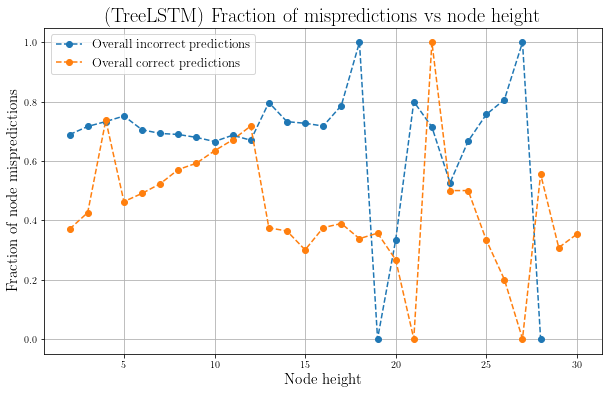

::: Configuring data :::
Train: 	 8544
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)


/Users/piyush/miniforge3/envs/nlp1labs/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


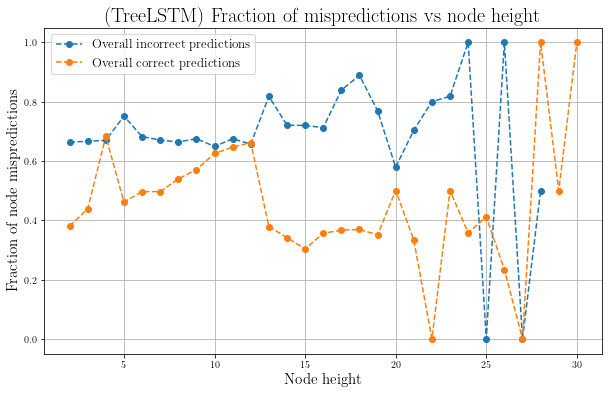

In [37]:
eval_args = {
    "batch_fn": get_minibatch,
    "prep_fn": prepare_treelstm_minibatch,
    "batch_size": 25,
}

seeds = [0, 42, 420]
model_name = "TreeLSTMClassifier"

for seed in seeds:
    # fix seed
    fix_seed(seed)

    # # load data
    train_data, dev_data, test_data, v, t2i, i2t, vectors = setup_data(
        use_pretrained_embeddings=True,
        pretrained_embeddings_path="./googlenews.word2vec.300d.txt",
    )

    # load model
    model = setup_model(model_name, {"embedding_dim": 300, "hidden_dim": 150, "output_dim": 5,}, v=v)
    ckpt = torch.load(f"./checkpoints/TreeLSTMClassifier_seed_{seed}-best_model.ckpt")
    model.load_state_dict(ckpt["state_dict"])

    # load results for given model with given seed
    results = torch.load(f"./results/{model_name}_seed_{seed}-best_model-results.pt")

    # find the examples that were mispredictions at the root level
    mp_idx = [i for i, (p, t) in enumerate(zip(results['prediction'], results['target'])) if p != t]

    # find the examples that were correct predictions at the root level
    cp_idx = [i for i, (p, t) in enumerate(zip(results['prediction'], results['target'])) if p == t]
    
    mp_examples = [results["example"][i] for i in mp_idx]
    mp_targets = [results["target"][i] for i in mp_idx]
    mp_predictions = [results["prediction"][i] for i in mp_idx]

    cp_examples = [results["example"][i] for i in cp_idx]
    cp_targets = [results["target"][i] for i in cp_idx]
    cp_predictions = [results["prediction"][i] for i in cp_idx]
    
    # get model predictions vs node height
    mp_mispredictions_vs_height, mp_all_vs_height = get_node_mispredictions_vs_height(model, mp_examples)
    cp_mispredictions_vs_height, cp_all_vs_height = get_node_mispredictions_vs_height(model, cp_examples)
    
    mp_df = construct_df_of_misprediction_fraction(mp_mispredictions_vs_height, mp_all_vs_height)
    cp_df = construct_df_of_misprediction_fraction(cp_mispredictions_vs_height, cp_all_vs_height)
    
    # plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    ax.plot(mp_df.height.sort_values(), mp_df.mispredictions.sort_index(), "--o", label="Overall incorrect predictions")
    ax.plot(cp_df.height.sort_values(), cp_df.mispredictions.sort_index(), "--o", label="Overall correct predictions")
    ax.grid()

    ax.set_title("(TreeLSTM) Fraction of mispredictions vs node height", fontsize=20)

    ax.set_xlabel("Node height", fontsize=15)
    ax.set_ylabel("Fraction of node mispredictions", fontsize=15)
    
    ax.legend(fontsize=13)
    plt.savefig(f"./results/node_mispredictions_seed_{seed}.pdf", bbox_inches="tight")
    plt.show()

This shows that the misprediction rate is relatively lower for low-height nodes, i.e. for unigrams and bigrams, the model seems  to be more accurate. However, as it goes to longer phrases, the misprediction rate increases. This may be due to accumulation of errors from lower nodes.

### Supervision at every node (TreeLSTM)

In [383]:
expt_args = {
    "model_name": "TreeLSTMClassifier",
    "model_args": {
        "embedding_dim": 300,
        "hidden_dim": 150,
        "output_dim": 5,
    },
    "optim_args": {
        "lr": 2e-4,
    },
    "train_args": {
        "num_iterations": 50000,
        "print_every": 250,
        "eval_every": 250,
        "batch_size": 25,
        "batch_fn": get_minibatch,
        "eval_fn": evaluate,
        "prep_fn": prepare_treelstm_minibatch,
    },
    "verbose": False,
    "use_pretrained_embeddings": True,
    "pretrained_embeddings_path": "./googlenews.word2vec.300d.txt",
    "expt_name": "subtrees",
    "use_subtrees": True,
}

:::::::::::::::::::::::: Seed : 0 ::::::::::::::::::::::::
.... Using supervision from subtrees ....
Training data size (before): 8544
Training data size (after): 318582
::: Configuring data :::
Train: 	 318582
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
TreeLSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (treelstm): TreeLSTM(
    (reduce): TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=False
treelstm.reduce.reduce_layer.weight [750, 300]   requires_grad=True
treelstm.reduce.reduce_layer.bias [750]        

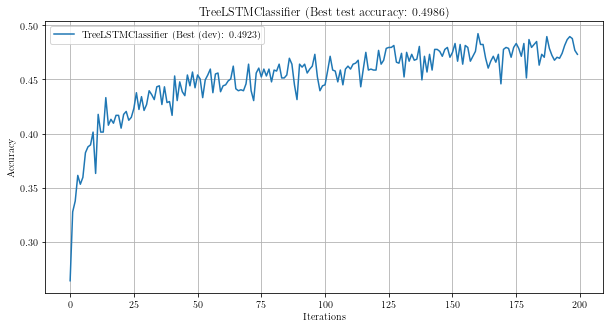

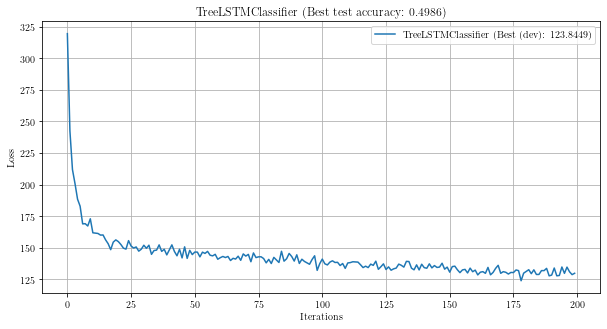

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 42 ::::::::::::::::::::::::
.... Using supervision from subtrees ....
Training data size (before): 8544
Training data size (after): 318582
::: Configuring data :::
Train: 	 318582
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
TreeLSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (treelstm): TreeLSTM(
    (reduce): TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=False
treelstm.reduce

/Users/piyush/miniforge3/envs/nlp1labs/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Done training
Loading best model
best model iter 47500: train acc=0.8017, dev acc=0.4914, test acc=0.4959
::: Configuring plotting :::


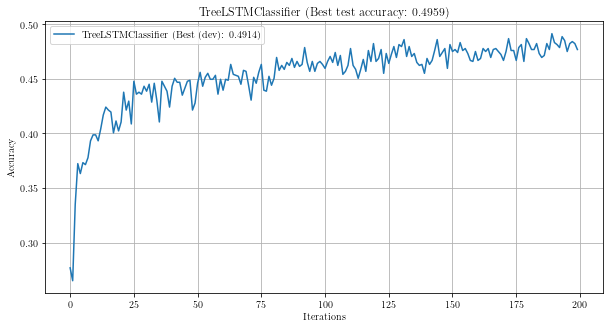

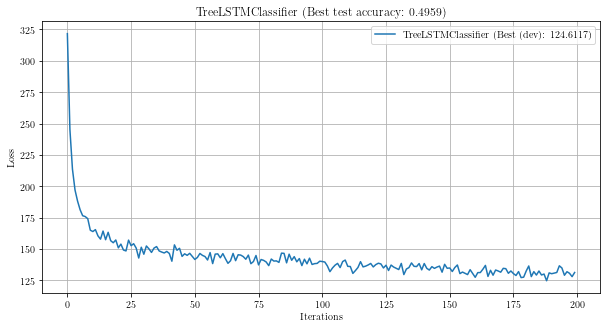

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 420 ::::::::::::::::::::::::
.... Using supervision from subtrees ....
Training data size (before): 8544
Training data size (after): 318582
::: Configuring data :::
Train: 	 318582
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
TreeLSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (treelstm): TreeLSTM(
    (reduce): TreeLSTMCell(300, 150)
    (proj_x): Linear(in_features=300, out_features=150, bias=True)
    (proj_x_gate): Linear(in_features=300, out_features=150, bias=True)
    (buffers_dropout): Dropout(p=0.5, inplace=False)
  )
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=150, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=False
treelstm.reduc

/Users/piyush/miniforge3/envs/nlp1labs/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Done training
Loading best model
best model iter 35000: train acc=0.7949, dev acc=0.4923, test acc=0.4932
::: Configuring plotting :::


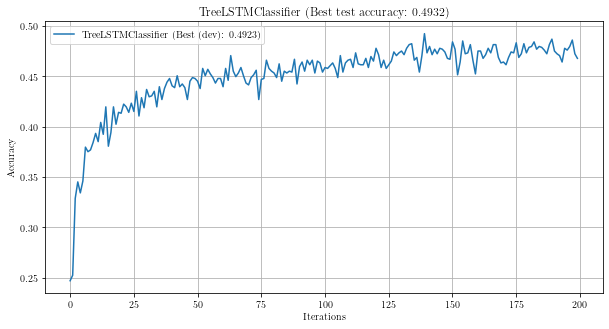

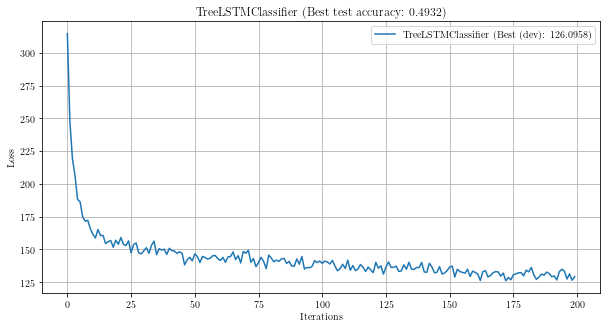

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
train	: Mean	: 0.7984 Std	: 0.0028
dev	: Mean	: 0.4920 Std	: 0.0004
test	: Mean	: 0.4959 Std	: 0.0022


In [384]:
best_agg_acc = run_multiple_seed_experiments(expt_args)

In [385]:
for phase in best_agg_acc:
    print(
        f"{phase}\t: Mean\t: {np.mean(best_agg_acc[phase]):.4f} Std\t: {np.std(best_agg_acc[phase]):.4f}"
    )

train	: Mean	: 0.7984 Std	: 0.0028
dev	: Mean	: 0.4920 Std	: 0.0004
test	: Mean	: 0.4959 Std	: 0.0022


### Node-level supervision (LSTM)

In [421]:
expt_args = {
    "model_name": "LSTMClassifier",
    "model_args": {
        "embedding_dim": 300,
        "hidden_dim": 168,
        "output_dim": 5,
    },
    "optim_args": {
        "lr": 2e-4,
    },
    "train_args": {
        "num_iterations": 30000,
        "print_every": 250,
        "eval_every": 250,
        "batch_fn": get_minibatch,
        "prep_fn": prepare_minibatch,
        "batch_size": 25,
        "eval_fn": evaluate,
    },
    "use_pretrained_embeddings": True,
    "pretrained_embeddings_path": "./googlenews.word2vec.300d.txt",
    "expt_name": "subtrees",
    "use_subtrees": True,
    "verbose": False,
}

:::::::::::::::::::::::: Seed : 0 ::::::::::::::::::::::::
.... Using supervision from subtrees ....
Training data size (before): 8544
Training data size (after): 318582
::: Configuring data :::
Train: 	 318582
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
LSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=False
rnn.input_projectors.weight [672, 1200]  requires_grad=True
rnn.input_projectors.bias [672]        requires_grad=True
rnn.hidden_projectors.weight [672, 672]   requires_grad=True
rnn.hidden_projectors.bias [672]        requires_grad=True
output_layer.1.weight    [5, 168]     requires_grad=True
output_layer.1.bias      [5]          requires_grad

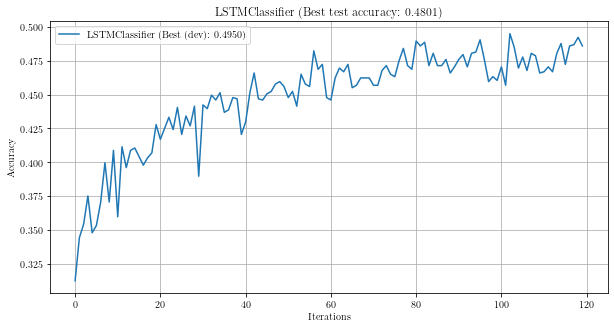

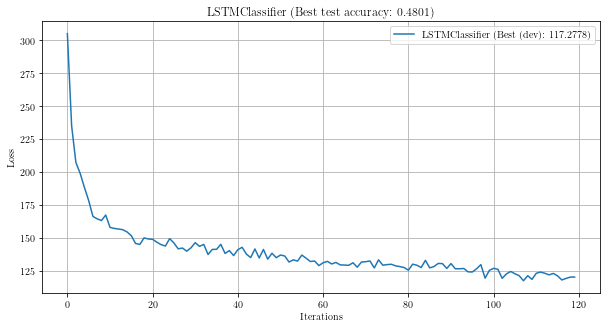

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 42 ::::::::::::::::::::::::
.... Using supervision from subtrees ....
Training data size (before): 8544
Training data size (after): 318582
::: Configuring data :::
Train: 	 318582
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
LSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=False
rnn.input_projectors.weight [672, 1200]  requires_grad=True
rnn.input_projectors.bias [672]        requires_grad=True
rnn.hidden_projectors.weight [672, 672]   requires_grad=True
rnn.hidden_projectors.bias [672]        requires_grad=True
output_l

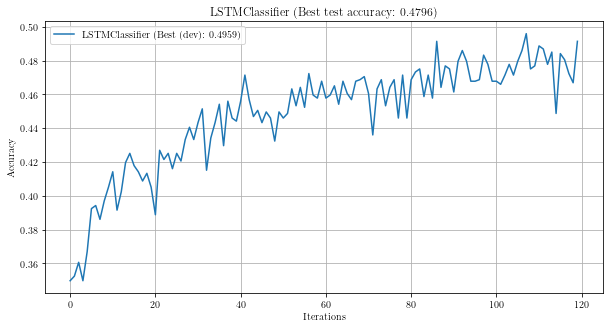

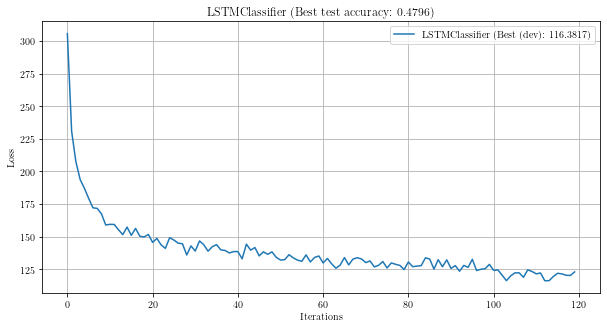

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
:::::::::::::::::::::::: Seed : 420 ::::::::::::::::::::::::
.... Using supervision from subtrees ....
Training data size (before): 8544
Training data size (after): 318582
::: Configuring data :::
Train: 	 318582
Dev: 	 1101
Test:	 2210
::: Using word-embeddings to create vocabulary. :::
Vocabulary size: 18922 	 Vectors shape:  (18922, 300)
::: Configuring model :::
LSTMClassifier(
  (embed): Embedding(18922, 300, padding_idx=1)
  (rnn): MyLSTMCell(300, 168)
  (output_layer): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=168, out_features=5, bias=True)
  )
)
embed.weight             [18922, 300] requires_grad=False
rnn.input_projectors.weight [672, 1200]  requires_grad=True
rnn.input_projectors.bias [672]        requires_grad=True
rnn.hidden_projectors.weight [672, 672]   requires_grad=True
rnn.hidden_projectors.bias [672]        requires_grad=True
output_

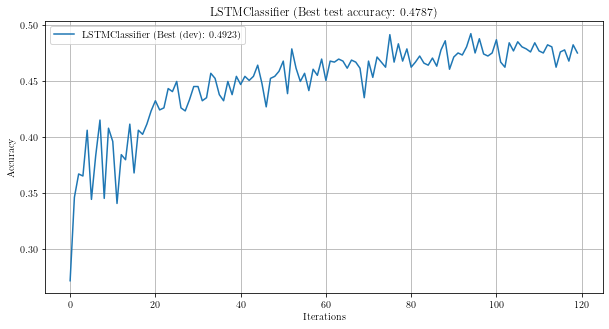

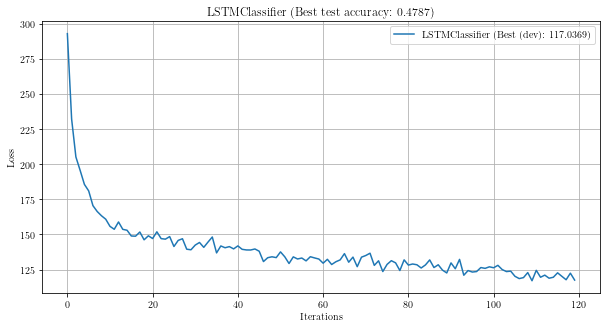

::: Saving checkpoint and logs :::
:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
train	: Mean	: 0.8159 Std	: 0.0013
dev	: Mean	: 0.4944 Std	: 0.0015
test	: Mean	: 0.4795 Std	: 0.0006


In [422]:
best_agg_acc = run_multiple_seed_experiments(expt_args)

In [423]:
for phase in best_agg_acc:
    print(
        f"{phase}\t: Mean\t: {np.mean(best_agg_acc[phase]):.4f} Std\t: {np.std(best_agg_acc[phase]):.4f}"
    )

train	: Mean	: 0.8159 Std	: 0.0013
dev	: Mean	: 0.4944 Std	: 0.0015
test	: Mean	: 0.4795 Std	: 0.0006


# Dataset analysis

Relevant/interesting questions:

1. What is the label distribution? Is it balanced? Is it skewed towards a specific class?
2. How does the distribution of validation set labels compare with that of train set?
3. What is the distribution of words given a class? E.g. do words like `brilliant`, `magnificient` etc come often in class 4? 
    * Firstly, it shows the importance of stemming and lemmatization
    * <Let's plot after preprocessing>
4. Given a word, how many times does it occur in sentences for varying labels?
5. Does the sentence length play a confounder in classification?

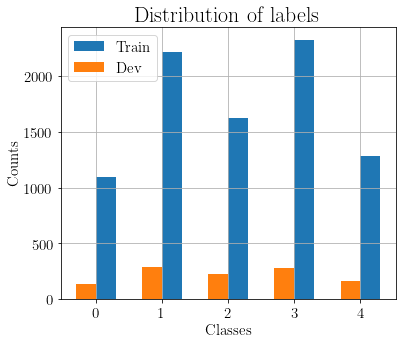

In [393]:
train_labels = np.array([x.label for x in train_data])
dev_labels = np.array([x.label for x in dev_data])

plot_multiple_categorical_histogram(
    [train_labels, dev_labels], labels=["Train", "Dev"], title="Distribution of labels",
    save=True, save_path="./results/label_dist.pdf", titlesize=22, labelsize=15,
)

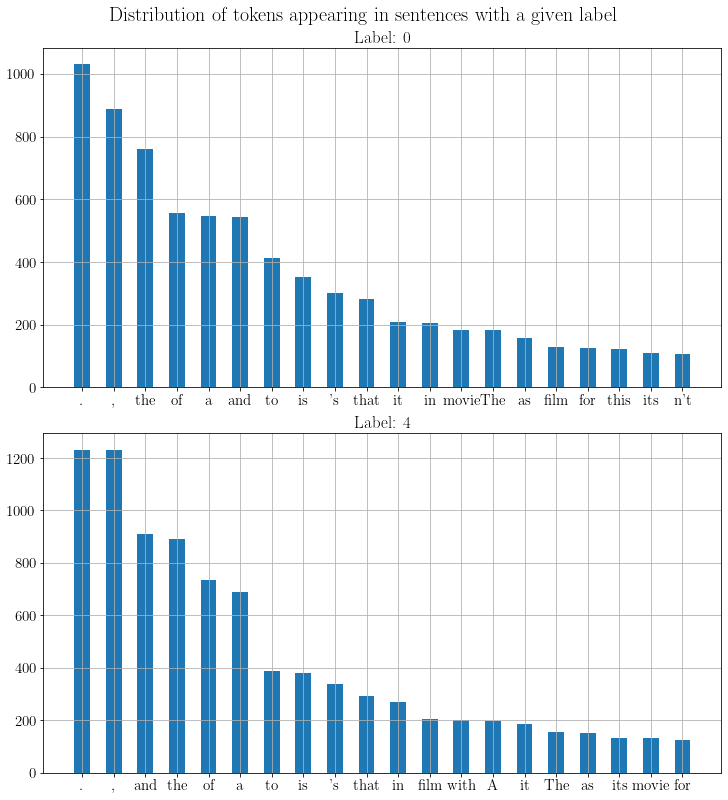

In [401]:
def filter_examples_by_label(examples, label):
    return [e for e in examples if e.label == label]

titlesize=20
labelsize=17
tickssize=15

fig, axes = plt.subplots(2, 1, figsize=(10, 11), constrained_layout=True)

for idx, label in enumerate([0, 4]):
    i = idx // 2
    j = idx % 2

    labelled_examples = filter_examples_by_label(train_data, label=label)
    tokens = []
    for e in labelled_examples:
        tokens.extend(e.tokens)
    unique_tokens, token_counts = np.unique(tokens, return_counts=True)
    token_idx = np.argsort(-token_counts)
    unique_tokens = unique_tokens[token_idx][:20]
    token_counts = token_counts[token_idx][:20]
    
    plot_single_categorical_histogram(
        x=unique_tokens, counts=token_counts, figsize=(8, 4), ax=axes[j],
        title=f"Label: {label}", xlabel="", ylabel="", titlesize=labelsize,
    )

plt.suptitle("Distribution of tokens appearing in sentences with a given label", fontsize=titlesize)

plt.savefig("./results/dist_tokens_in_labels_0_4.pdf", bbox_inches="tight")
plt.show()

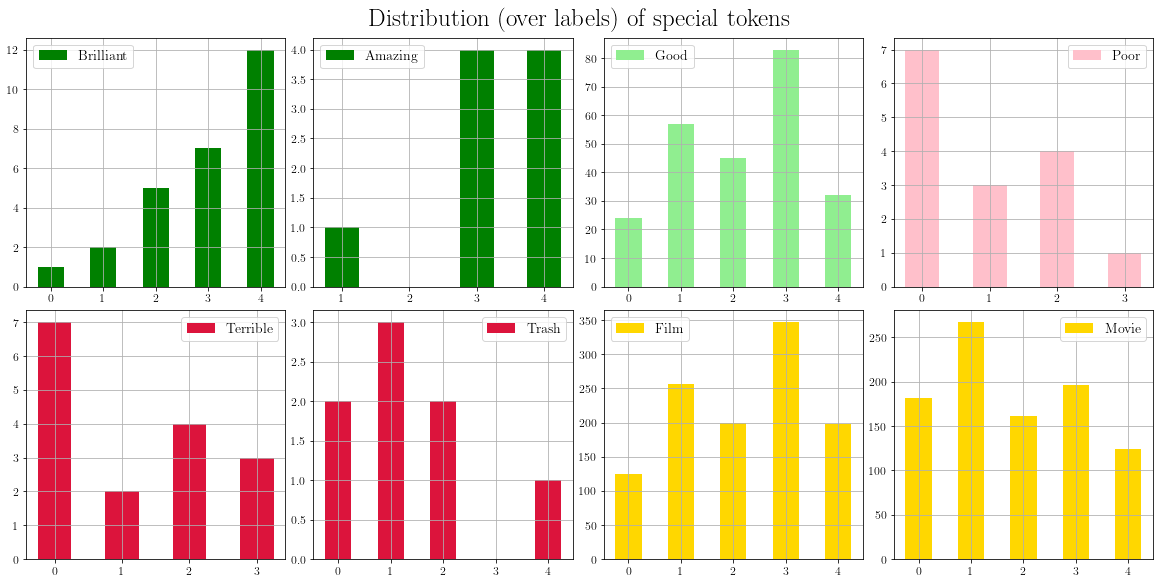

In [411]:
words = ["brilliant", "amazing", "good", "poor", "terrible", "trash", "film", "movie"]
colors = ["green", "green", "lightgreen", "pink", "crimson", "crimson", "gold", "gold"]


fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)

for idx, word in enumerate(words):
    i, j = idx // 4, idx % 4

    labels = [e.label for e in train_data if word in e.tokens]
    plot_single_categorical_histogram(
        values=labels, ax=axes[i, j],
        title="", xlabel="", ylabel="", bar_label=f"{word.capitalize()}",
        titlesize=12, tickssize=12, labelsize=14, color=colors[idx]
    )

plt.suptitle("Distribution (over labels) of special tokens", fontsize=25)
plt.savefig("./results/special_tokens.pdf", bbox_inches="tight")
plt.show()

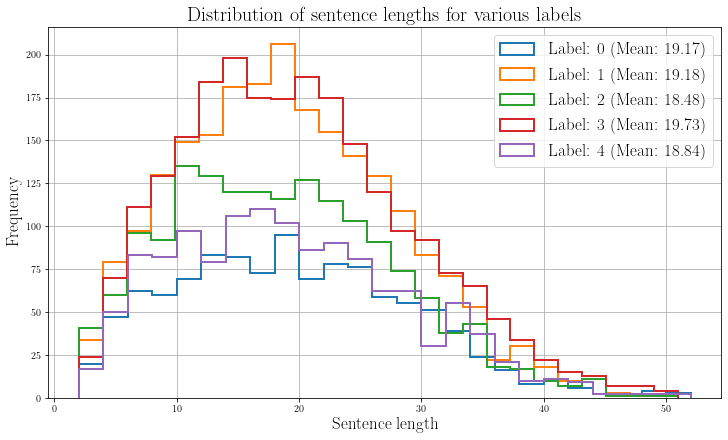

In [414]:
train_sentence_lengths = np.array([len(e.tokens) for e in train_data])

titlesize=20
labelsize=17
tickssize=15

fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)

for label in [0, 1, 2, 3, 4]:
    sent_lens = train_sentence_lengths[train_labels == label]
    ax.hist(sent_lens, density=False, linewidth=2.0, histtype="step", label=f"Label: {label} (Mean: {np.mean(sent_lens):.2f})", bins=25)
    
ax.grid()
ax.legend(fontsize=labelsize)
ax.set_title("Distribution of sentence lengths for various labels", fontsize=titlesize)
ax.set_xlabel("Sentence length", fontsize=labelsize)
ax.set_ylabel("Frequency", fontsize=labelsize)

plt.savefig("./results/dist_sent_lens.pdf", bbox_inches="tight")
plt.show()

# Further experiments and report

For your report, you are expected to answer research questions by doing further experiments.

## Research Questions

Make sure you cover at least the following:

- How important is word order for this task?
- Does the tree structure help to get a better accuracy?
- How does performance depend on the sentence length? Compare the various models. Is there a model that does better on longer sentences? If so, why?
- Do you get better performance if you supervise the sentiment **at each node in the tree**? You can extract more training examples by treating every node in each tree as a separate tree. You will need to write a function that extracts all subtrees given a treestring. 
    - Warning: NLTK's Tree function seems to result in invalid trees in some cases, so be careful if you want to parse the string to a tree structure before extraction the phrases.

**To be able to obtain a full grade (10), you should conduct further investigations.** For example, you can also investigate one the following:

- When making a wrong prediction, can you figure out at what point in the tree (sentence) the model fails? You can make a prediction at each node to investigate.
- How does N-ary Tree LSTM compare to the Child-Sum Tree LSTM? 
- How do the Tai et al. Tree LSTMs compare to Le & Zuidema's formulation?
- Or... your own research question!

These examples should give you an idea of the expected scope of your further investigations.

In general:

- ***When you report numbers, please report the mean accuracy across 3 (or more) runs with different random seed, together with the standard deviation.*** This is because the final performance may vary per random seed. 
More precisely, you should run each model with 3 different seeds, and for each of these 3 runs, evaluate the best model (according to the validation) on the test dataset. The validation dataset is used for finding the best model over iterations, but the accuracy you report should be on the test dataset.

## Report instructions

Your report needs to be written in LaTeX. You are required to use the ACL 2020 template which you can download from or edit directly on [Overleaf](https://www.overleaf.com/latex/templates/instructions-for-acl-2018-proceedings/xzmhqgnmkppc). Make sure your names and student numbers are visible at the top. (Tip: you need to uncomment `\aclfinalcopy`).
You can find some general tips about writing a research paper [here](https://www.microsoft.com/en-us/research/academic-program/write-great-research-paper/), but note that you need to make your own judgment about what is appropriate for this project. 

We expect you to use the following structure:
1. Introduction (~1 page) - describe the problem, your research questions and goals, a summary of your findings and contributions. Please cite related work (models, data set) as part of your introduction here, since this is a short paper.
    - Introduce the task and the main goal
    - Present your research questions
    - Motivate the importance of the questions
    - Present and explain your expectations
    - Make clear whether the research questions are addressed or not addressed in the literature
    - Describe the approach you use to answer the research questions
    - Summarise your findings
2. Background (~1/2-1 page) -
cover the main techniques ("building blocks") used in your project (e.g. word embeddings, LSTM, Tree-LSTM) and intuitions behind them. Be accurate and concise.
    - How does each technique work? (Don't just copy the formulas)
    - What is the relation between the techniques?
3. Models (~1/2 page) - Describe the architecture of the final models.
    - How do you use LSTM or Tree-LSTM for the sentiment classification task? 
    - What layers do you have, how do you do classification? 
    - What is your loss function?
    - Etc.
4. Experiments (~1/2 page) - Describe your experimental setup. This section should allow someone else to reproduce your experiments. Describe how you evaluate the models.
    - Task and the data
    - Training (model, data, parameters and hyper parameters, training algorithms, supervision signals, etc.)
    - Evaluation (e.g. metrics)
5. Results and Analysis (~1 page). Present the results and analyse your findings.
    - Answer each of the research questions you raised in the introduction.
    - Use figures and tables to highlight interesting patterns
    - What are the factors that make model A better than model B in task C? Investigate to prove their effect!
6. Conclusion (~1/4 page). Present the conclusions that can be drawn from your experiments.
    - What have you learned from you experiments?
    - How do your findings relate to what is already known in the literature?
    - Were the results as expected? Any surprising results? Why?
    - Based on what you learned, what would you suggest doing next?


General Tips:

- Math notation – define each variable (either in running text, or in a pseudo-legenda after or before the equation).
- Define technical terminology you need.
- Avoid colloquial language – everything can be said in a scientific-sounding way.
- Avoid lengthy sentences, stay to the point.
- Do not spend space on "obvious" things.
- Do not go over the page limit. (We will deduct points for that.)
- The page limit is 4 pages excluding references and appendix. This is a strict limit; points will be deducted for longer reports. 
- There is no strict limit to references and appendix. However, the report needs to remain fully self-contained: the appendix should only include content that is not necessary to understand your work. For example, preprocessing decisions, model parameters, pseudocode, sample system inputs/outputs, and other details that are necessary for the exact replication of your work can be put into the appendix. 


An ideal report:
- Precise, scientific-sounding, technical, to the point 
  - Little general “waffle”/chit-chat
- Not boring – because you don’t explain obvious things too much
- Efficient delivery of (only) the facts that we need to know to understand/reimplement
- Results visually well-presented and described with the correct priority of importance of sub-results
- Insightful analysis – speculation should connect to something interesting and not be too much; the reader “learns something new”
- No typos, no colloquialisms – well-considered language
- This normally means several re-draftings (re-orderings of information)
